In [13]:
import matplotlib.pyplot as plt
import pandas as pd, numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from collections import Counter
import pickle

df = pd.read_csv('./data.csv')
model_file = "./model.sav"

df.drop(["Unnamed: 0"],  axis=1, inplace=True)

In [14]:
attractions_cols = list(range(7,21))

df_user_prefs = df.drop(df.columns[attractions_cols], axis=1)

In [15]:
df_user_prefs.head(5)

,age,gender,open_closed_spaces,classical_new_places,fast_slow_trip,more_short_less_long_trip,alone_company,music_style_Forró/Sertanejo,music_style_MPB,music_style_Pop,...,fav_scenario_Montanha,fav_scenario_Praia,fav_place_Lojas/shoppings/centros comercias,fav_place_Museus,fav_place_Parques,fav_place_Restaurantes típicos,fav_place_Trilhas,transport_Carro Alugado,transport_Transporte Público,transport_Táxi/Uber/99
0,23,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
1,24,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
2,21,1,0,0,1,1,0,0,0,1,...,0,0,1,0,0,0,0,1,0,0
3,24,1,0,0,1,1,0,1,0,0,...,0,1,0,0,1,0,0,0,0,1
4,26,0,0,0,0,1,0,1,0,0,...,0,1,0,0,0,1,0,0,0,1


In [16]:
scaler = StandardScaler()
normData = scaler.fit_transform(df_user_prefs)
df_user_prefs = pd.DataFrame(normData, columns=df_user_prefs.columns)

In [18]:
df_values = df_user_prefs.values
pca = PCA(n_components=2)
pca_values = pca.fit_transform(df_values)
pca_df = pd.DataFrame(data=pca_values, columns=['C1','C2'])

pca_df

,C1,C2
0,-0.300162,2.789604
1,0.928941,0.278072
2,-0.421324,3.621773
3,-3.935699,-2.368882
4,-1.151256,-1.469958
...,...,...
4020,-2.156722,-0.797244
4021,-0.352588,3.434757
4022,0.119845,-0.061291
4023,0.564053,-0.862807


# KMeans

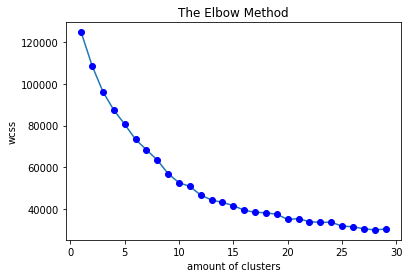

In [17]:
wcss = []
amount_clusters = range(1,30)

for n in amount_clusters:
    kmeans = KMeans(n_clusters=n, random_state=0)
    kmeans.fit(df_user_prefs)
    wcss.append(kmeans.inertia_)
  
plt.title('The Elbow Method')
plt.xlabel("amount of clusters")
plt.ylabel("wcss")
plt.plot(amount_clusters, wcss)
plt.plot(amount_clusters, wcss, 'bo')

In [19]:
def get_model(amt_clusters):
  try:
    model = pickle.load(open(model_file, 'rb'))
    labels = model.labels_
    print("Loaded model")
    return model
  except:
    print("Saved model")
    model = KMeans(n_clusters=amt_clusters, random_state=12345)
    pickle.dump(model, open(model_file, 'wb'))
    return model

model = get_model(9)
model.fit(df_user_prefs)
labels = model.predict(df_user_prefs)

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator KMeans from version 0.24.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Loaded model


Counter({1: 780, 0: 685, 5: 578, 8: 539, 4: 521, 3: 313, 2: 226, 7: 205, 6: 178})


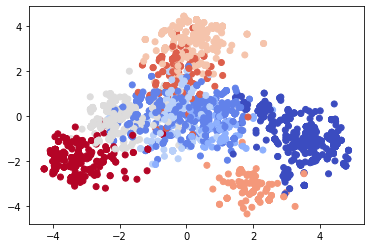

In [10]:
print(Counter(labels))
plt.scatter(pca_df['C1'], pca_df['C2'], c=labels, cmap="coolwarm")

# DBSCAN

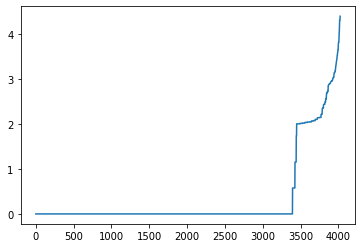

In [11]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(df_user_prefs)
distances, indices = nbrs.kneighbors(df_user_prefs)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

Estimated number of clusters: 67
Estimated number of noise points: 2259


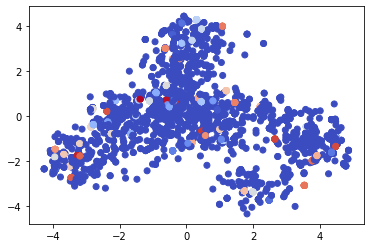

In [12]:
db = DBSCAN(eps=0.5, min_samples=10).fit(df_user_prefs)
labelsDBSCAN = db.labels_

n_clusters_ = len(set(labelsDBSCAN)) - (1 if -1 in labelsDBSCAN else 0)
n_noise_ = list(labelsDBSCAN).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
plt.scatter(pca_df['C1'], pca_df['C2'], c=labelsDBSCAN, cmap="coolwarm")

# Random Forest

In [21]:
x = df_user_prefs.values
y = labelsDBSCAN

classifier_rf = RandomForestClassifier(random_state=1986,
                           criterion='gini',
                           max_depth=10,
                           n_estimators=50,
                           n_jobs=-1)

param_grid = {
            "criterion": ['entropy', 'gini'],
            "n_estimators": [25, 50, 75],
            "bootstrap": [False, True],
            "max_depth": [3, 5, 10],
            "max_features": ['auto', 0.1, 0.2, 0.3]
}
grid_search = GridSearchCV(classifier_rf, param_grid, scoring="accuracy")
grid_search.fit(x, y)

classifier_rf = grid_search.best_estimator_ 
grid_search.best_params_, grid_search.best_score_

({'bootstrap': True,
  'criterion': 'entropy',
  'max_depth': 10,
  'max_features': 'auto',
  'n_estimators': 75},
 0.9518012422360249)